In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def f(x):
  return 4 * x**2 - 5 * x + 8

# def f(x):
  # return 3*x**2 - 4*x + 5

In [4]:
f(2/5)

6.640000000000001

In [5]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)

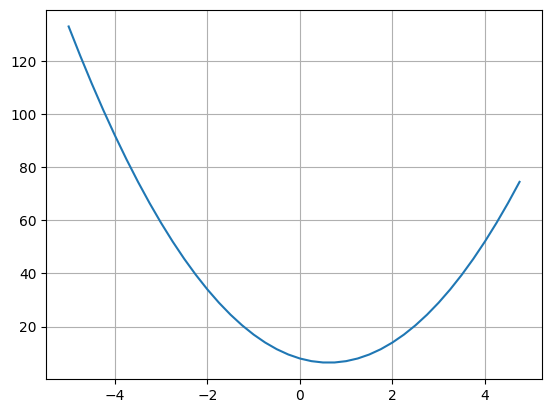

In [6]:
plt.plot(xs, ys)
plt.grid()
plt.show()

The derivative of a function ( f ) at a point ( x ) is defined as:
$$
f'(x) = \lim_{h \to 0} \frac{{f(x+h) - f(x)}}{h}
$$
provided this limit exists.

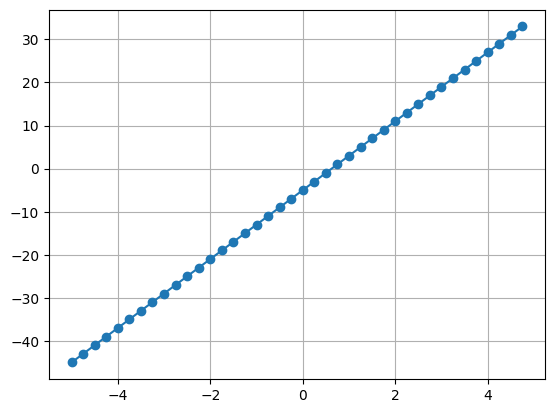

In [7]:
xs = np.arange(-5, 5, 0.25)
h = 0.0000000001
def der(x):
    return (f(x + h) - f(x))/h

ys_der = der(xs)
plt.plot(xs, ys_der, 'o-')
plt.grid()
plt.show()

In [8]:
a = 3.0
b = 4.5
c = -5

d = a*b + c
d

8.5

In [9]:
a = 3.0
b = -4.5
c = 10.0

d1 = a*b + c
h = 1e-5
c += h
d2 = a*b + c

print('d1 :', d1)
print('d2 :', d2)
print('slope :', (d2 - d1)/h)

d1 : -3.5
d2 : -3.4999900000000004
slope : 0.9999999999621422


In [10]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data: %.4f | grad: %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [44]:
import math

class Value:
    def __init__(self, data, _children=(), _op='', label='') -> None:
        self.data = data
        self._backward = lambda : None
        self._prev = set(_children)
        self.grad = 0
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out 
    
    def tanh(self):
        x = self.data
        # t = (math.exp(2*x) -1) / (math.exp(2*x) + 1)
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

a = Value(2, label='a')
b = Value(-3, label='b')
c = Value(10, label='c')
e = a * b; e.label='e'
d = e + c; d.label='d'
f = Value(-2,label='f')
L = d * f; L.label='L'
L

Value(data=-8)

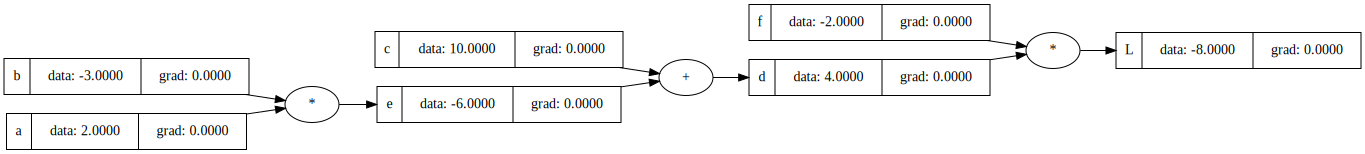

In [12]:
draw_dot(L)

In [13]:
a.grad = 6
b.grad = -4
c.grad = -2
e.grad = -2
f.grad = 4
d.grad = -2
L.grad = 1

In [14]:
a.data += 0.02 * a.grad
b.data += 0.02 * b.grad
c.data += 0.02 * c.grad
f.data += 0.02 * f.grad

e = a * b
d = e + c
L = d * f

print(L)

Value(data=-6.586368000000001)


In [15]:
def lol():
    h = 0.001
    a = Value(2, label='a')
    b = Value(-3, label='b')
    c = Value(10, label='c')
    e = a * b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2,label='f')
    L = d * f; L.label='L'
    L1 = L.data

    a = Value(2, label='a')
    b = Value(-3, label='b')
    c = Value(10, label='c')
    e = a * b; e.label='e'
    e.data += h
    d = e + c; d.label='d'
    f = Value(-2,label='f')
    L = d * f; L.label='L'
    L2 = L.data

    print((L2 - L1)/h)

lol()

-2.000000000000668


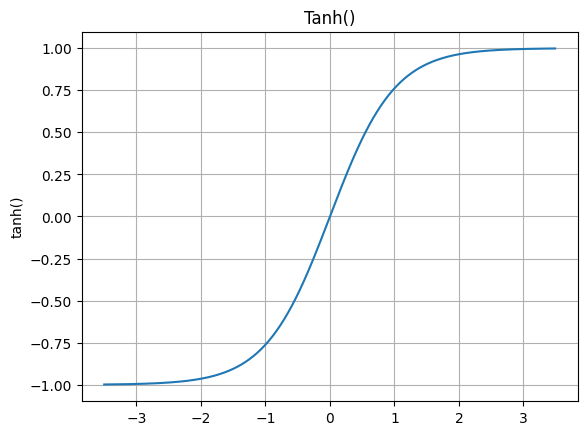

In [16]:
plt.plot(np.arange(-3.5, 3.5, 0.01), np.tanh(np.arange(-3.5, 3.5, 0.01)))
plt.grid()
plt.title('Tanh()')
plt.ylabel('tanh()')
plt.show()

<h2>Simple Neural Network</h2>

In [45]:
# Inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# Weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
b = Value(6.8813735870195432, label='b')
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'

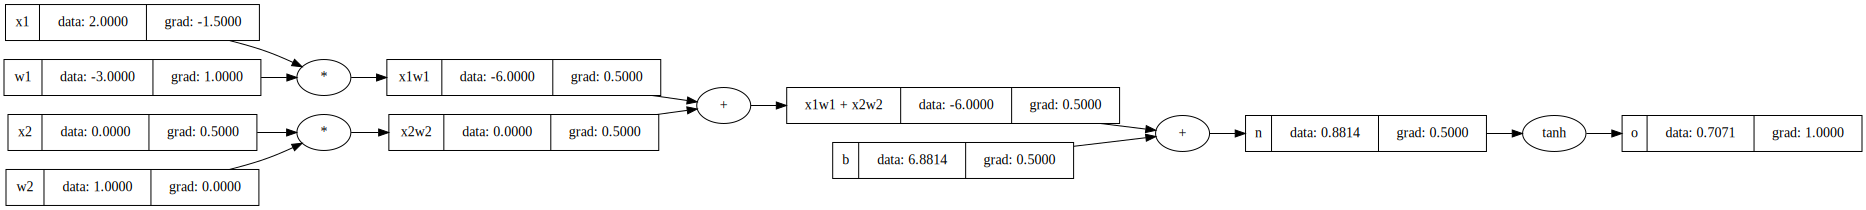

In [48]:
draw_dot(o)

In [47]:
o.backward()

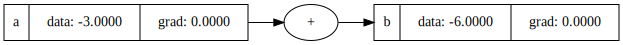

In [49]:
a = Value(data=-3.0, label='a')
b = a + a; b.label = 'b'
draw_dot(b)

In [50]:
b.backward()

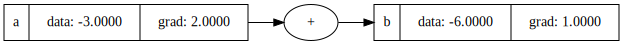

In [51]:
draw_dot(b)